# SR Example

First be sure the notebook is running with GPU.

Runtime -> Change Runtime Type -> GPU


***Le code fourni au départ est celui pour faire la Super Résolution***

# Charger les bibliothèques

In [ ]:
# Colab only
# download and install Pytorch

# ferdi 1

!pip install torch torchvision
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121


In [1]:
import platform

print(f"Python version: {platform.python_version()}")

import torch
torch.cuda.is_available()


Python version: 3.12.2


True

In [2]:
# import the packages
import numpy as np
from PIL import Image
from IPython.display import clear_output
import matplotlib.pyplot as plt

# import PyTorch (Deep Learning lib)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import math
import inspect  # debugage
import pandas as pd

C:\Users\ferdi\AppData\Local\Temp\ipykernel_160044\552055485.py:16: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# La Base de donnée

On a choisit de travailler avec CIFAR 10, des images RGB 32 par 32, avec 10 classes, 50000 données d'entrainement et 10000 données de test.


On a voulu au départ travailler avec la base de donnée CELEBA, mais celle si étant trop lourde, avec plus de 2000 classes, on s'est retrouvé face aux problèmes suivants :
- devoir charger les données prend beaucoup de temps (+ de 200000 images)
- le téléchargement devait se faire sur un lien drive qui autorisait un download par 24h
- google collab enregistre le code mais vide les fichiers entre chaque session, on a donc tout perdu après les efforts

On a choisit une solutions sans drive, pytorch offre directement un accès à la base de donnée CIFAR10, qu'on peut donc download a chaque session sans difficulté et rapidement (car plus légère).


In [28]:

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


print(trainset)

print(testset)


Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


On utilise une transformation pour normaliser les images $I \in [0, 1]^3$ de CIFAR-10 de façon à avoir $I_{norm} \in [-1, 1]^3$ :

$
I_{norm} = \frac{I - \mu}{\sigma}
$

d'ou $\mu = 0.5$ et $\sigma = 0.5$

La normalisation vise à centrer les valeurs autour de zéro et à les mettre à l'échelle de manière à avoir une variance relativement uniforme. Cela peut aider à stabiliser et à accélérer l'entraînement du modèle, en particulier lorsque vous utilisez des méthodes d'optimisation sensibles à l'échelle des données.

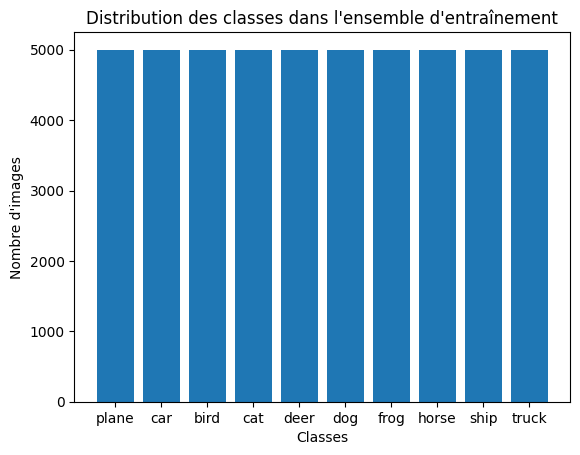

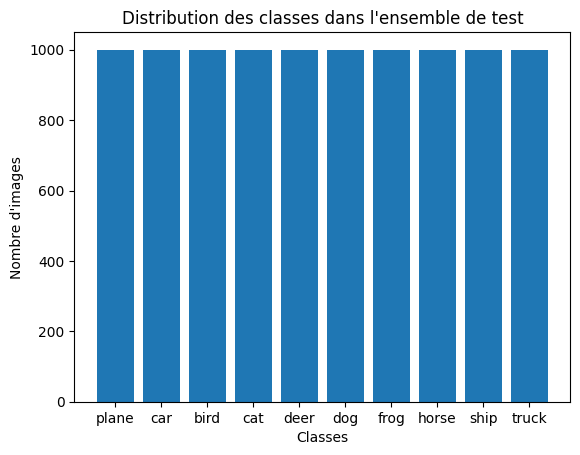

In [ ]:
# Fonction pour afficher le nombre d'images par classe
def show_class_distribution(dataset, set_name):
    class_counts = [0] * len(classes)
    for _, label in dataset:
        class_counts[label] += 1

    fig, ax = plt.subplots()
    ax.bar(classes, class_counts)
    ax.set_xlabel('Classes')
    ax.set_ylabel('Nombre d\'images')
    ax.set_title(f'Distribution des classes dans l\'ensemble {set_name}')
    plt.show()

# Afficher la distribution des classes dans l'ensemble d'entraînement
show_class_distribution(trainset, "d'entraînement")

# Afficher la distribution des classes dans l'ensemble de test
show_class_distribution(testset, "de test")

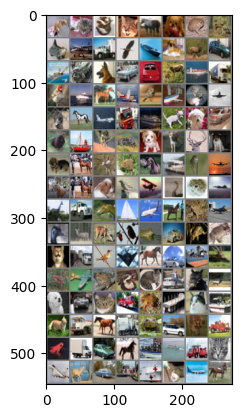

batch_size = 128 et dimension d'une image = torch.Size([3, 32, 32])
dog   cat   cat   cat   horse dog   frog  deer  cat   plane truck bird  ship  dog   deer  car   plane frog  dog   car   car   deer  ship  truck bird  ship  horse plane bird  plane deer  plane bird  horse plane truck ship  dog   dog   car   dog   ship  dog   frog  dog   dog   deer  dog   dog   horse deer  frog  horse ship  bird  plane horse horse dog   bird  plane bird  frog  plane bird  truck horse ship  plane horse frog  plane bird  deer  deer  bird  frog  truck frog  frog  cat   truck bird  plane horse car   ship  deer  frog  plane frog  dog   cat   car   horse deer  dog   car   cat   truck frog  truck cat   ship  cat   truck horse truck frog  car   deer  truck frog  truck car   horse ship  ship  truck cat   plane deer  car   truck ship  cat   plane horse


In [14]:
# afficher un batch : (cette case peut être run autant de fois qu'on veut)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)



# show images
imshow(torchvision.utils.make_grid(images))
print(f"batch_size = {images.shape[0]} et dimension d'une image = {images.shape[1:]}")
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


# Le modèle simple

Dans cette partie, on va suivre le tutoriel de classification de pytorch (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).


## Création du Réseau :

Dans le tuto, on utilise la structure suivante :



In [7]:

class S_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        ## conv1 puis pool :
        x = self.pool(F.relu(self.conv1(x)))
        ## conv2 puis pool :
        x = self.pool(F.relu(self.conv2(x)))
        ## flatten :
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        ## fully connected 1 :
        x = F.relu(self.fc1(x))
        ## fully connected 2 :
        x = F.relu(self.fc2(x))
        ## fully connected 3 :
        x = self.fc3(x)
        return x

    def size_debug(self, x):
        forward_source = inspect.getsource(self.forward)
        forward_lines = forward_source.split('\n')[1:-2]  # Skip def and return
        local_vars = locals()
        print("in :")
        print(x.shape)
        for line in forward_lines:
            if line.strip():
                if line.strip()[0] != '#':
                    exec(line.strip(), globals(), local_vars)
                    x = local_vars['x']
                    print(x.shape)
                elif line.strip()[0:2] == '##':
                    print(line.strip())
        print("out.")


net = S_Net()
net = net.cuda()

net.size_debug(images.cuda())


in :
torch.Size([128, 3, 32, 32])
## conv1 puis pool :
torch.Size([128, 6, 14, 14])
## conv2 puis pool :
torch.Size([128, 16, 5, 5])
## flatten :
torch.Size([128, 400])
## fully connected 1 :
torch.Size([128, 120])
## fully connected 2 :
torch.Size([128, 84])
## fully connected 3 :
torch.Size([128, 10])
out.


## Optimization :

Dans le tuto, on utilise comme fonction de permet la Cross Entropy, et comme algorithme d'optimisation, la descente de  gradient stochastique.

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
n_epochs = 6

for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        L = 50
        if i % L == L-1:    # print every L mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / L:.3f}')
            running_loss = 0.0
            
    PATH = f"./cifar_net_tuto_epoch{epoch}_batch{batch_size}.pth"
    torch.save(net.state_dict(), PATH)

print('Finished Training')




[1,    50] loss: 1.871
[1,   100] loss: 1.854
[1,   150] loss: 1.863
[1,   200] loss: 1.849
[1,   250] loss: 1.828
[1,   300] loss: 1.815
[1,   350] loss: 1.807
[2,    50] loss: 1.764
[2,   100] loss: 1.793
[2,   150] loss: 1.760
[2,   200] loss: 1.761
[2,   250] loss: 1.736
[2,   300] loss: 1.713
[2,   350] loss: 1.720
[3,    50] loss: 1.689
[3,   100] loss: 1.667
[3,   150] loss: 1.662
[3,   200] loss: 1.653
[3,   250] loss: 1.645
[3,   300] loss: 1.636
[3,   350] loss: 1.648
[4,    50] loss: 1.610
[4,   100] loss: 1.616
[4,   150] loss: 1.601
[4,   200] loss: 1.563
[4,   250] loss: 1.567
[4,   300] loss: 1.587
[4,   350] loss: 1.579
[5,    50] loss: 1.550
[5,   100] loss: 1.555
[5,   150] loss: 1.530
[5,   200] loss: 1.536
[5,   250] loss: 1.528
[5,   300] loss: 1.539
[5,   350] loss: 1.503
[6,    50] loss: 1.493
[6,   100] loss: 1.511
[6,   150] loss: 1.505
[6,   200] loss: 1.511
[6,   250] loss: 1.488
[6,   300] loss: 1.509
[6,   350] loss: 1.478
Finished Training


In [ ]:
# save the model
PATH = f"./cifar_net_tuto_n_epochs={n_epochs}.pth"
torch.save(net.state_dict(), PATH)

## Evaluation du modèle :

In [ ]:
# tester le modele : (cette case peut être run autant de fois qu'on veut)

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


net = S_Net()
net = net.cuda()
net.load_state_dict(torch.load(PATH))

outputs = net(images.cuda())

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))


In [10]:
# tester sur tout le test dataset :

accuracy_test = []
accuracy_train = []

for epoch in range(n_epochs):
    print(f"epoch #{epoch}")
    PATH = f"./cifar_net_tuto_epoch{epoch}_batch{batch_size}.pth"
    
    net = S_Net()
    net = net.cuda()
    net.load_state_dict(torch.load(PATH))

    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the {len(testset)} test images: {100 * correct / total} %')
    accuracy_test.append(100 * correct / total)
    
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the {len(trainset)} train images: {100 * correct / total} %')
    accuracy_train.append(100 * correct / total)




epoch #0
Accuracy of the network on the 10000 test images: 35.71 %
Accuracy of the network on the 50000 train images: 35.46 %
epoch #1
Accuracy of the network on the 10000 test images: 38.77 %
Accuracy of the network on the 50000 train images: 38.61 %
epoch #2


KeyboardInterrupt: 

Accuracy for class: plane is 49.1 %
Accuracy for class: car   is 56.5 %
Accuracy for class: bird  is 16.1 %
Accuracy for class: cat   is 18.7 %
Accuracy for class: deer  is 31.5 %
Accuracy for class: dog   is 42.8 %
Accuracy for class: frog  is 58.4 %
Accuracy for class: horse is 53.4 %
Accuracy for class: ship  is 31.9 %
Accuracy for class: truck is 56.8 %


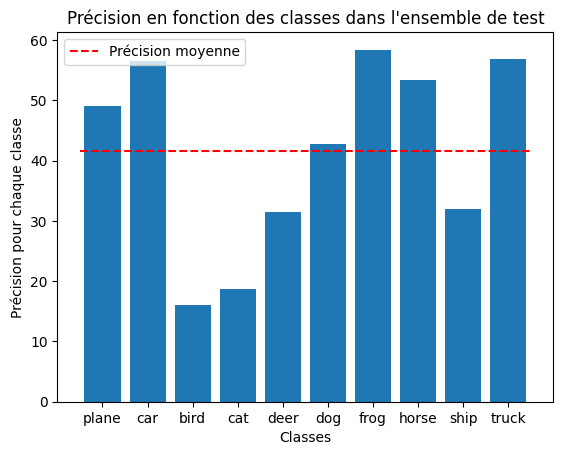

In [11]:
# précision en fonction des classes :

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class

noms_classe = []
precisions_classe = []
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    noms_classe.append(classname)
    precisions_classe.append(accuracy)
precision_moyenne = np.mean(precisions_classe)


fig, ax = plt.subplots()
ax.bar(noms_classe, precisions_classe)
ax.plot([-0.5,9.5], [precision_moyenne, precision_moyenne], '--r', label='Précision moyenne')
ax.set_xlabel('Classes')
ax.set_ylabel("Précision pour chaque classe")
ax.set_title("Précision en fonction des classes dans l'ensemble de test")
ax.legend()
plt.show()


# Le Modèle PARKHI

In [29]:
# create the neural network with Pytorch
class P_Net(nn.Module):
  
  def __init__(self, in_channels, out_channels):
    
    super().__init__()

    self.in_channels = in_channels

    S = 32

    self.conv11 = nn.Conv2d(in_channels, S, kernel_size=3, padding=1)
    self.bn11 = nn.BatchNorm2d(S)
    self.conv12 = nn.Conv2d(S, S, kernel_size=3, padding=1)
    self.bn12 = nn.BatchNorm2d(S)

    self.conv21 = nn.Conv2d(S, 2*S, kernel_size=3, padding=1)
    self.bn21 = nn.BatchNorm2d(2*S)
    self.conv22 = nn.Conv2d(2*S, 2*S, kernel_size=3, padding=1)
    self.bn22 = nn.BatchNorm2d(2*S)

    self.conv31 = nn.Conv2d(2*S, 2*2*S, kernel_size=3, padding=1)
    self.bn31 = nn.BatchNorm2d(2*2*S)
    self.conv32 = nn.Conv2d(2*2*S, 2*2*S, kernel_size=3, padding=1)
    self.bn32 = nn.BatchNorm2d(2*2*S)
    self.conv33 = nn.Conv2d(2*2*S, 2*2*S, kernel_size=3, padding=1)
    self.bn33 = nn.BatchNorm2d(2*2*S)

    self.conv41 = nn.Conv2d(2*2*S, 2*2*2*S, kernel_size=3, padding=1)
    self.bn41 = nn.BatchNorm2d(2*2*2*S)
    self.conv42 = nn.Conv2d(2*2*2*S, 2*2*2*S, kernel_size=3, padding=1)
    self.bn42 = nn.BatchNorm2d(2*2*2*S)
    self.conv43 = nn.Conv2d(2*2*2*S, 2*2*2*S, kernel_size=3, padding=1)
    self.bn43 = nn.BatchNorm2d(2*2*2*S)

    self.conv51 = nn.Conv2d(2*2*2*S, 2*2*2*S, kernel_size=3, padding=1)
    self.bn51 = nn.BatchNorm2d(2*2*2*S)
    self.conv52 = nn.Conv2d(2*2*2*S, 2*2*2*S, kernel_size=3, padding=1)
    self.bn52 = nn.BatchNorm2d(2*2*2*S)
    self.conv53 = nn.Conv2d(2*2*2*S, 2*2*2*S, kernel_size=3, padding=1)
    self.bn53 = nn.BatchNorm2d(2*2*2*S)

    self.fc6 = nn.Linear(in_features=2*2*2*S, out_features=4096)
    self.fc7 = nn.Linear(in_features=4096, out_features=4096)  
    self.fc8 = nn.Linear(in_features=4096, out_features=10)


  def forward(self, x):
                  ## Stage 1
    ## conv11 :
    x = F.relu(self.bn11(self.conv11(x)))
    ## conv12 :
    x = F.relu(self.bn12(self.conv12(x)))
    ## maxpool :
    x = F.max_pool2d(x, kernel_size=2, stride=2)
                  ## Stage 2
    ## conv21 :
    x = F.relu(self.bn21(self.conv21(x)))
    ## conv22 :
    x = F.relu(self.bn22(self.conv22(x)))
    ## maxpool :
    x = F.max_pool2d(x, kernel_size=2, stride=2)
                  ## Stage 3
    ## conv31 :
    x = F.relu(self.bn31(self.conv31(x)))
    ## conv32 :
    x = F.relu(self.bn32(self.conv32(x)))
    ## conv33 :
    x = F.relu(self.bn33(self.conv33(x)))
    ## maxpool :
    x = F.max_pool2d(x, kernel_size=2, stride=2)
                  ## Stage 4
    ## conv41 :
    x = F.relu(self.bn41(self.conv41(x)))
    ## conv42 :
    x = F.relu(self.bn42(self.conv42(x)))
    ## conv43 :
    x = F.relu(self.bn43(self.conv43(x)))
    ## maxpool :
    x = F.max_pool2d(x, kernel_size=2, stride=2)
                  ## Stage 5
    ## conv51 :
    x = F.relu(self.bn51(self.conv51(x)))
    ## conv52 :
    x = F.relu(self.bn52(self.conv52(x)))
    ## conv53 :
    x = F.relu(self.bn53(self.conv53(x)))
    ## maxpool :
    x = F.max_pool2d(x, kernel_size=2, stride=2)
    ## flatten :
    x = torch.flatten(x, 1)
                  ## Stage 6
    ## fully connected 6 :
    x = F.relu(self.fc6(x))
                  ## Stage 7
    ## fully connected 7 :
    x = F.relu(self.fc7(x))
                  ## Stage 8
    ## fully connected 8 :
    x = F.relu(self.fc8(x))

    return x
  
  def size_debug(self, x):
        forward_source = inspect.getsource(self.forward)
        forward_lines = forward_source.split('\n')[1:-2]  # Skip def and return
        local_vars = locals()
        print("in :")
        print(x.shape)
        for line in forward_lines:
            if line.strip():
                if line.strip()[0] != '#':
                    exec(line.strip(), globals(), local_vars)
                    x = local_vars['x']
                    print(x.shape)
                elif line.strip()[0:2] == '##':
                    print(line.strip())
        print("out.")

# actual network creation
net = P_Net(3,3)
net.cuda() # go GPU

dataiter = iter(trainloader)
images, labels = next(dataiter)
net.size_debug(images.cuda())

in :
torch.Size([128, 3, 32, 32])
## Stage 1
## conv11 :
torch.Size([128, 32, 32, 32])
## conv12 :
torch.Size([128, 32, 32, 32])
## maxpool :
torch.Size([128, 32, 16, 16])
## Stage 2
## conv21 :
torch.Size([128, 64, 16, 16])
## conv22 :
torch.Size([128, 64, 16, 16])
## maxpool :
torch.Size([128, 64, 8, 8])
## Stage 3
## conv31 :
torch.Size([128, 128, 8, 8])
## conv32 :
torch.Size([128, 128, 8, 8])
## conv33 :
torch.Size([128, 128, 8, 8])
## maxpool :
torch.Size([128, 128, 4, 4])
## Stage 4
## conv41 :
torch.Size([128, 256, 4, 4])
## conv42 :
torch.Size([128, 256, 4, 4])
## conv43 :
torch.Size([128, 256, 4, 4])
## maxpool :
torch.Size([128, 256, 2, 2])
## Stage 5
## conv51 :
torch.Size([128, 256, 2, 2])
## conv52 :
torch.Size([128, 256, 2, 2])
## conv53 :
torch.Size([128, 256, 2, 2])
## maxpool :
torch.Size([128, 256, 1, 1])
## flatten :
torch.Size([128, 256])
## Stage 6
## fully connected 6 :
torch.Size([128, 4096])
## Stage 7
## fully connected 7 :
torch.Size([128, 4096])
## Stage 8
#

In [30]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# # create the optimizer
# optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
# criterion = F.mse_loss # ça marche pas ici parce que il faut criterion(outputs, labels) avec outputs et labels de meme size (pq ??)
# criterion = nn.CrossEntropyLoss()

In [31]:

n_epochs = 20

for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        L = 80
        if i % L == L-1:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / L:.3f}')
            running_loss = 0.0
            
    PATH = f"./cifar_net_parkhi_epoch{epoch}_batch{batch_size}.pth"
    torch.save(net.state_dict(), PATH)

print('Finished Training')



[1,    80] loss: 2.230
[1,   160] loss: 1.999
[1,   240] loss: 1.873
[1,   320] loss: 1.799
[2,    80] loss: 1.524
[2,   160] loss: 1.447
[2,   240] loss: 1.398
[2,   320] loss: 1.357
[3,    80] loss: 1.205
[3,   160] loss: 1.207
[3,   240] loss: 1.203
[3,   320] loss: 1.187
[4,    80] loss: 1.026
[4,   160] loss: 1.049
[4,   240] loss: 1.069
[4,   320] loss: 1.051
[5,    80] loss: 0.926
[5,   160] loss: 0.936
[5,   240] loss: 0.939
[5,   320] loss: 0.947
[6,    80] loss: 0.820
[6,   160] loss: 0.837
[6,   240] loss: 0.856
[6,   320] loss: 0.874
[7,    80] loss: 0.737
[7,   160] loss: 0.779
[7,   240] loss: 0.777
[7,   320] loss: 0.805
[8,    80] loss: 0.689
[8,   160] loss: 0.715
[8,   240] loss: 0.721
[8,   320] loss: 0.757
[9,    80] loss: 0.645
[9,   160] loss: 0.656
[9,   240] loss: 0.669
[9,   320] loss: 0.709
[10,    80] loss: 0.619
[10,   160] loss: 0.611
[10,   240] loss: 0.631
[10,   320] loss: 0.651
[11,    80] loss: 0.590
[11,   160] loss: 0.623
[11,   240] loss: 0.611
[11,

In [ ]:
# save the model
PATH = f"./cifar_net_parkhi_n_epochs={n_epochs}.pth"
torch.save(net.state_dict(), PATH)

In [ ]:
# tester le modele : (cette case peut être run autant de fois qu'on veut)

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


net = NetP(3,3)
net.load_state_dict(torch.load(PATH))
#net.cuda()

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))


In [32]:
# tester sur tout le test dataset :

accuracy_test = []
accuracy_train = []

for epoch in range(n_epochs):
    print(f"epoch #{epoch}")
    PPATH = f"./cifar_net_parkhi_epoch{epoch}_batch{batch_size}.pth"
    
    net = P_Net(3, 3)
    net = net.cuda()
    net.load_state_dict(torch.load(PATH))

    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the {len(testset)} test images: {100 * correct / total} %')
    accuracy_test.append(100 * correct / total)
    
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the {len(trainset)} train images: {100 * correct / total} %')
    accuracy_train.append(100 * correct / total)



epoch #0
Accuracy of the network on the 10000 test images: 70.09 %
Accuracy of the network on the 50000 train images: 87.578 %
epoch #1
Accuracy of the network on the 10000 test images: 70.09 %
Accuracy of the network on the 50000 train images: 87.548 %
epoch #2
Accuracy of the network on the 10000 test images: 70.09 %
Accuracy of the network on the 50000 train images: 87.61 %
epoch #3
Accuracy of the network on the 10000 test images: 70.09 %
Accuracy of the network on the 50000 train images: 87.63 %
epoch #4
Accuracy of the network on the 10000 test images: 70.09 %
Accuracy of the network on the 50000 train images: 87.612 %
epoch #5
Accuracy of the network on the 10000 test images: 70.09 %
Accuracy of the network on the 50000 train images: 87.63 %
epoch #6
Accuracy of the network on the 10000 test images: 70.09 %
Accuracy of the network on the 50000 train images: 87.62 %
epoch #7
Accuracy of the network on the 10000 test images: 70.09 %
Accuracy of the network on the 50000 train image

Accuracy for class: plane is 66.4 %
Accuracy for class: car   is 87.8 %
Accuracy for class: bird  is 70.9 %
Accuracy for class: cat   is 59.0 %
Accuracy for class: deer  is 74.7 %
Accuracy for class: dog   is 0.0 %
Accuracy for class: frog  is 84.7 %
Accuracy for class: horse is 83.2 %
Accuracy for class: ship  is 87.8 %
Accuracy for class: truck is 86.4 %


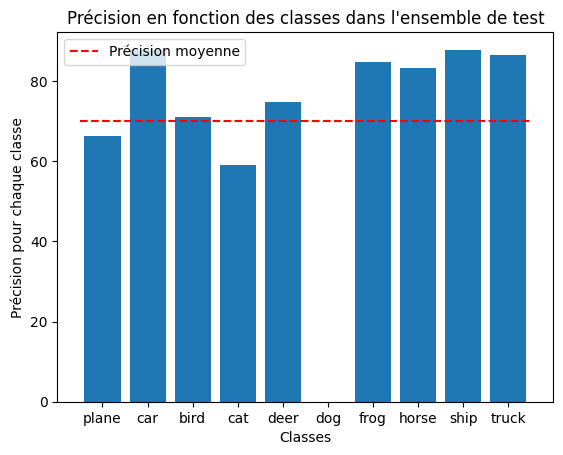

In [33]:
# précision en fonction des classes :

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class

noms_classe = []
precisions_classe = []
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    noms_classe.append(classname)
    precisions_classe.append(accuracy)
precision_moyenne = np.mean(precisions_classe)


fig, ax = plt.subplots()
ax.bar(noms_classe, precisions_classe)
ax.plot([-0.5,9.5], [precision_moyenne, precision_moyenne], '--r', label='Précision moyenne')
ax.set_xlabel('Classes')
ax.set_ylabel("Précision pour chaque classe")
ax.set_title("Précision en fonction des classes dans l'ensemble de test")
ax.legend()
plt.show()
